In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import math
import time
import os
import sys

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transformer, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transformer, download=True)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter =torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter =torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter
batch_size =256
train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=224)

In [15]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 224, 224])

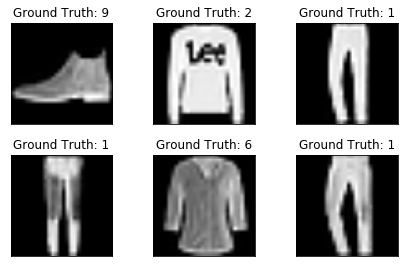

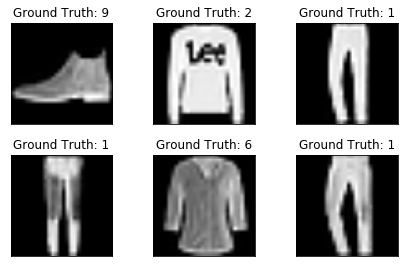

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:

def train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        net.train() # Switch to training mode
        n, start = 0, time.time()
        train_l_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        train_acc_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device) 
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
            % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

In [0]:
def evaluate_accuracy(data_iter, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Switch to evaluation mode for Dropout, BatchNorm etc layers.
    acc_sum, n = torch.tensor([0], dtype=torch.float32, device=device), 0
    for X, y in data_iter:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0]
    return acc_sum.item()/n

In [0]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use torch.is_grad_enabled() to determine whether the current mode is training mode or
    # prediction mode
    if not torch.is_grad_enabled():
        # If it is the prediction mode, directly use the mean and variance
        # obtained from the incoming moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcast operation
            # can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance of the moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

In [0]:

class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter involved in gradient
        # finding and iteration are initialized to 0 and 1 respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # All the variables not involved in gradient finding and iteration are
        # initialized to 0 on the CPU
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        # If X is not on the CPU, copy moving_mean and moving_var to the
        # device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),
                    nn.BatchNorm2d(6),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.BatchNorm2d(16),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    Flatten(),
                    nn.Linear(256, 120),
                    nn.BatchNorm1d(120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.BatchNorm1d(84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

In [35]:

lr, num_epochs, batch_size, device = 1, 10, 256, 'cuda:0'

#Initialization of Weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

criterion = nn.CrossEntropyLoss()

train_iter, test_iter = load_data_fashion_mnist(batch_size)

train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0025, train acc 0.767, test acc 0.655, time 8.2 sec
epoch 2, loss 0.0015, train acc 0.856, test acc 0.759, time 8.1 sec
epoch 3, loss 0.0013, train acc 0.874, test acc 0.866, time 8.1 sec
epoch 4, loss 0.0012, train acc 0.885, test acc 0.854, time 8.1 sec
epoch 5, loss 0.0012, train acc 0.892, test acc 0.855, time 8.2 sec
epoch 6, loss 0.0011, train acc 0.897, test acc 0.821, time 8.2 sec
epoch 7, loss 0.0011, train acc 0.901, test acc 0.839, time 8.2 sec
epoch 8, loss 0.0010, train acc 0.905, test acc 0.806, time 8.2 sec
epoch 9, loss 0.0010, train acc 0.907, test acc 0.831, time 8.2 sec
epoch 10, loss 0.0009, train acc 0.911, test acc 0.818, time 8.2 sec


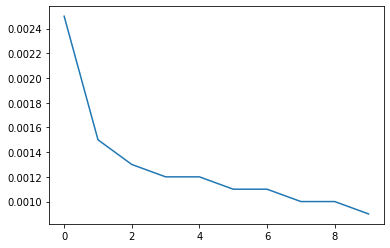

In [40]:
loss=[0.0025,0.0015,0.0013,0.0012,0.0012,0.0011,0.0011,0.0010,0.0010,0.0009]
plt.plot(loss)

In [41]:
examples = enumerate(test_iter)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 28, 28])

In [0]:

with torch.no_grad():
  net.to('cpu')
  output = net(example_data)

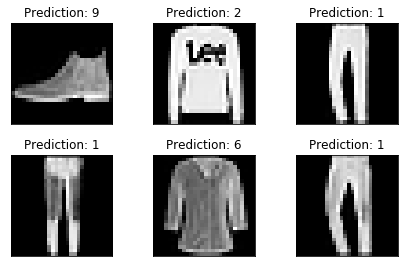

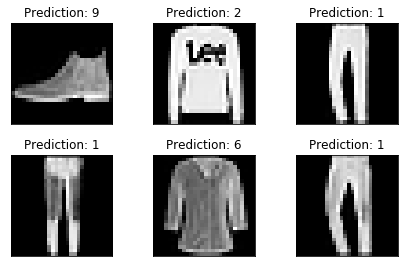

In [43]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig